In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")
cur = con.cursor()
fires = pd.read_sql('SELECT * FROM fires', con)
print(fires.shape)
con.close()

(1880465, 39)


In [3]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()
discovery_dates = pd.to_datetime(fires['DISCOVERY_DATE'] - epoch, unit='D')
fires['DISCOVERY_DATE']=discovery_dates

In [4]:
fires = fires.sort_values(by=['DISCOVERY_DATE'])

In [5]:
fires

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
774670,774671,878199,SCHMIDT_56011992,NONFED,ST-WYWYS,ST/C&L,USWYWYS,Wyoming State Forestry,WYWYS,Wyoming State Forestry,...,A,41.642490,-108.245102,14.0,MISSING/NOT SPECIFIED,WY,Sweetwater,037,Sweetwater,b'\x00\x01\xad\x10\x00\x00\xcc\xd1\r\xc1\xaf\x...
961584,961585,1089849,TFS_FL_39954,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS12,FLS Orlando District,...,B,28.300000,-80.730000,14.0,MISSING/NOT SPECIFIED,FL,Brevard,009,Brevard,b'\x00\x01\xad\x10\x00\x00\x1c\x85\xebQ\xb8.T\...
961583,961584,1089848,TFS_FL_39953,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS18,FLS Everglades District,...,C,25.950000,-80.450000,14.0,MISSING/NOT SPECIFIED,FL,Miami Dade,086,Miami-Dade,b'\x00\x01\xad\x10\x00\x00\xcc\xcc\xcc\xcc\xcc...
603990,603991,651826,SFO-TX01430692-10422355,NONFED,ST-NASF,ST/C&L,USTXHAS,Texas Forest Service - Henderson Area,TXHAS,Texas Forest Service - Henderson Area,...,B,31.664580,-94.589580,14.0,MISSING/NOT SPECIFIED,TX,Nacogdoches,347,Nacogdoches,b'\x00\x01\xad\x10\x00\x00\x08\x98\xc0\xad\xbb...
746120,746121,845656,SC_24841,NONFED,ST-SCSCS,ST/C&L,USSCSCS,South Carolina Forestry Commission,SCSCS,South Carolina Forestry Commission,...,B,33.379167,-80.620833,14.0,MISSING/NOT SPECIFIED,SC,38,075,Orangeburg,"b""\x00\x01\xad\x10\x00\x00x'\xb8\xbb\xbb'T\xc0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849700,1849701,300276766,SFO-2015TXPRI593558,NONFED,ST-NASF,ST/C&L,USTXTXS,Texas A & M Forest Service,TXPRI,Texas Forest Service,...,A,34.244730,-102.828169,14.0,MISSING/NOT SPECIFIED,TX,Bailey,017,Bailey,b'\x00\x01\xad\x10\x00\x00\xe4\xa3\x8c\xb8\x00...
1829982,1829983,300250027,SFO-2015TXPRI592861,NONFED,ST-NASF,ST/C&L,USTXTXS,Texas A & M Forest Service,TXPRI,Texas Forest Service,...,A,31.658725,-97.473990,14.0,MISSING/NOT SPECIFIED,TX,Bosque,035,Bosque,"b""\x00\x01\xad\x10\x00\x00`('\xdaU^X\xc0\xd0\x..."
1832050,1832051,300253490,SFO-2015TXLFDX594882,NONFED,ST-NASF,ST/C&L,USTXTXS,Texas A & M Forest Service,TXLFDX,Local Fire Department,...,B,32.116021,-96.325207,14.0,MISSING/NOT SPECIFIED,TX,Navarro,349,Navarro,b'\x00\x01\xad\x10\x00\x00\x88[\x051\xd0\x14X\...
1831007,1831008,300251694,SFO-2015TXLFDX594491,NONFED,ST-NASF,ST/C&L,USTXTXS,Texas A & M Forest Service,TXLFDX,Local Fire Department,...,A,32.439411,-94.947366,14.0,MISSING/NOT SPECIFIED,TX,Gregg,183,Gregg,b'\x00\x01\xad\x10\x00\x00\x1cv\x95\xa4\xa1\xb...


In [6]:
fires['DISCOVERY_DATE']

774670    1992-01-01
961584    1992-01-01
961583    1992-01-01
603990    1992-01-01
746120    1992-01-01
             ...    
1849700   2015-12-31
1829982   2015-12-31
1832050   2015-12-31
1831007   2015-12-31
1801138   2015-12-31
Name: DISCOVERY_DATE, Length: 1880465, dtype: datetime64[ns]

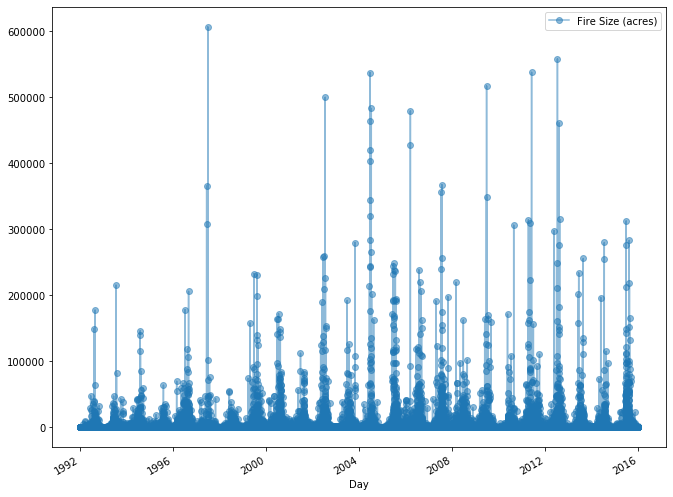

In [7]:
fires.rename(columns={"DISCOVERY_DATE": "Day", "FIRE_SIZE": "Fire Size (acres)"}).plot(x='Day', y='Fire Size (acres)', marker='o', linestyle='-', alpha=0.5, figsize=(11, 9), legend=True)

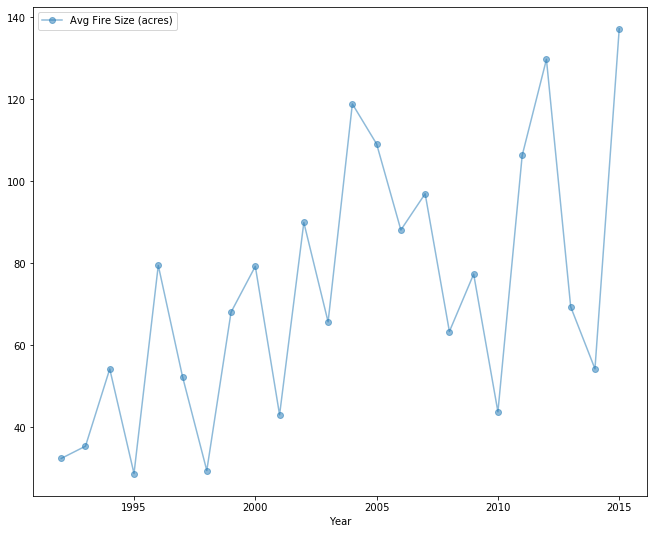

In [8]:
fires_by_year = fires.groupby([fires["DISCOVERY_DATE"].dt.year])["FIRE_SIZE"].mean().rename_axis('Year').rename(level = 0, index = 'Avg Fire Size (acres)')
fires_by_year.plot(y='Avg Fire Size (acres)', marker='o', linestyle='-', alpha=0.5, figsize=(11, 9), legend=True)

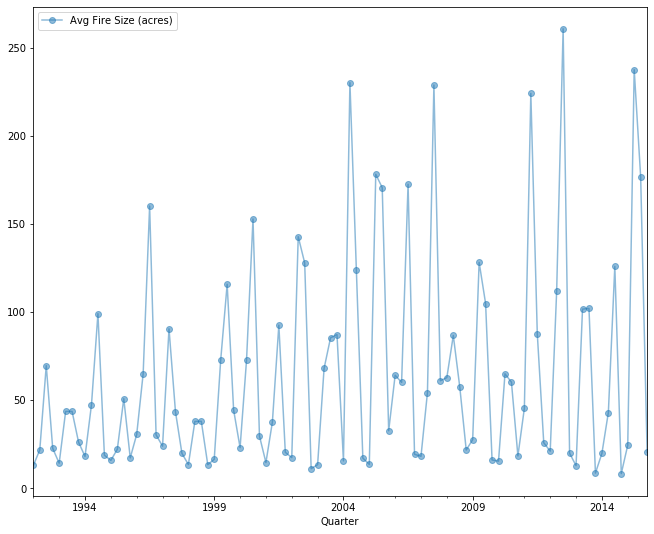

In [9]:
fires_by_quarter = fires.groupby(pd.Grouper(key="DISCOVERY_DATE", freq='Q'))["FIRE_SIZE"].mean().rename_axis('Quarter').rename(level = 0, index = 'Avg Fire Size (acres)')
fires_by_quarter.plot(x='YEAR', y='FIRE_SIZE', marker='o', linestyle='-', alpha=0.5, figsize=(11, 9), legend=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


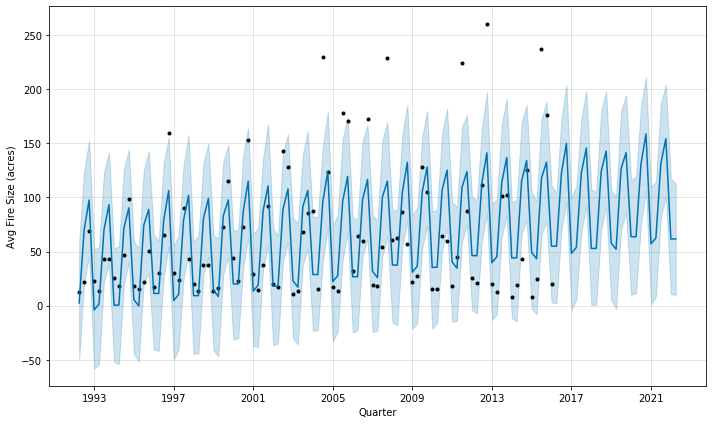

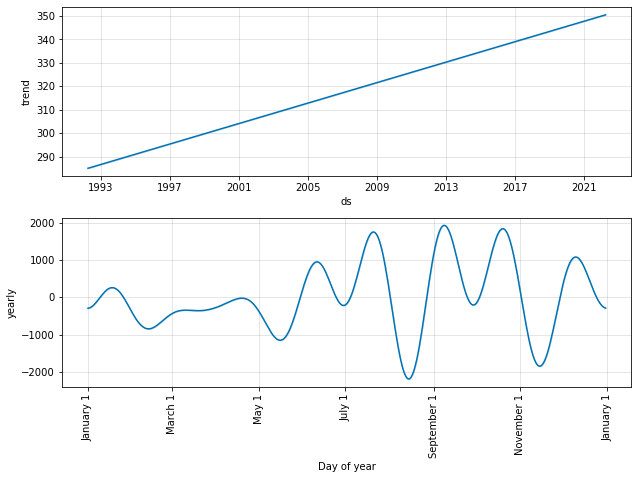

In [54]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

fdf = pd.DataFrame({'ds': fires_by_quarter.index.values.tolist(), 'y': fires_by_quarter.values.tolist()})
dates = pd.to_datetime(fdf['ds'])
fdf['ds']=dates

prophet = Prophet()
prophet.fit(fdf)
future = prophet.make_future_dataframe(periods=25, freq='Q')
forecast = prophet.predict(future)
fig = prophet.plot(forecast, xlabel='Quarter', ylabel='Avg Fire Size (acres)')

fig2 = prophet.plot_components(forecast)
plt.xticks(rotation=90)
plt.show()

In [12]:
# ARIMA model